<a href="https://colab.research.google.com/github/kaz2ngt/colaboratory/blob/master/9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 事前準備: ドライブのマウントとデータの取得

In [0]:
# Google ドライブをマウントするには、このセルを実行してください。
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# 下記でdriveからコピーして解凍
!cp drive/My\ Drive/Colab\ Notebooks/9img.zip ./
!unzip 9img.zip

# リストPART2

In [0]:
import os
import glob
import math
import random

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Conv2D, Dense, Input, MaxPooling2D, UpSampling2D, Lambda
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator

# 9_1: データの読み込み

In [0]:
data_path = 'img/colorize'
data_lists = glob.glob(os.path.join(data_path, '*.jpg'))

val_n_sample = math.floor(len(data_lists)*0.1)
test_n_sample = math.floor(len(data_lists)*0.1)
train_n_sample = len(data_lists) - val_n_sample - test_n_sample

val_lists = data_lists[:val_n_sample]
test_lists = data_lists[val_n_sample:val_n_sample + test_n_sample]
train_lists = data_lists[val_n_sample + test_n_sample:train_n_sample + val_n_sample + test_n_sample]

# 9_2: 前処理：「RGB」を「LAB」に変換

In [0]:
import cv2

img_size = 224
def rgb2lab(rgb):
  assert rgb.dtype == 'uint8'
  return cv2.cvtColor(rgb, cv2.COLOR_RGB2Lab)

def lab2rgb(lab):
  assert lab.dtype == 'uint8'
  return cv2.cvtColor(lab, cv2.COLOR_Lab2RGB)

def get_lab_from_data_list(data_list):
  x_lab = []
  for f in data_list:
    rgb = img_to_array(
        load_img(
            f,
            target_size=(img_size, img_size)
        )
    ).astype(np.uint8)
    lab = rgb2lab(rgb)
    x_lab.append(lab)
  return np.stack(x_lab)

# 9_3: モデルの構築

In [0]:
from tensorflow.python.keras.layers import Conv2DTranspose

autoencoder = Sequential()
# Encoder
autoencoder.add(
    Conv2D(
        32,
        (3, 3),
        (1, 1),
        activation='relu',
        padding='same',
        input_shape=(224, 224, 1)
    )
)
autoencoder.add(
    Conv2D(
        64,
        (3, 3),
        (2, 2),
        activation='relu',
        padding='same'
    )
)
autoencoder.add(
    Conv2D(
        128,
        (3, 3),
        (2, 2),
        activation='relu',
        padding='same'
    )
)
autoencoder.add(
    Conv2D(
        256,
        (3, 3),
        (2, 2),
        activation='relu',
        padding='same'
    )
)
# Decoder
autoencoder.add(
    Conv2DTranspose(
        128,
        (3, 3),
        (2, 2),
        activation='relu',
        padding='same'
    )
)
autoencoder.add(
    Conv2DTranspose(
        64,
        (3, 3),
        (2, 2),
        activation='relu',
        padding='same'
    )
)
autoencoder.add(
    Conv2DTranspose(
        32,
        (3, 3),
        (2, 2),
        activation='relu',
        padding='same'
    )
)
autoencoder.add(
    Conv2D(
        2,
        (1, 1),
        (1, 1),
        activation='relu',
        padding='same'
    )
)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

W0702 05:00:02.172159 139759452002176 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       295168    
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 56, 56, 128)       295040    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 112, 112, 64)      73792     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 224, 224, 32)      1

# 9_4: モデルのサマリの確認

In [0]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       295168    
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 56, 56, 128)       295040    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 112, 112, 64)      73792     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 224, 224, 32)      1

# 9_5: ジェネレータ関数の定義

In [0]:
def generator_with_preprocessing(data_list, batch_size, shuffle=False):
  while True:
    if shuffle:
      np.random.shuffle(data_list)
    for i in range(0, len(data_list), batch_size):
      batch_list = data_list[i:i + batch_size]
      batch_lab = get_lab_from_data_list(batch_list)
      batch_l = batch_lab[:, :, :, 0:1]
      batch_ab = batch_lab[:, :, :, 1:]
      yield (batch_l, batch_ab)

#9_6: 学習・検証・評価用のジェネレータの呼び出し

In [0]:
batch_size = 30

train_gen = generator_with_preprocessing(train_lists, batch_size, shuffle=True)
val_gen = generator_with_preprocessing(val_lists, batch_size)
test_gen = generator_with_preprocessing(test_lists, batch_size)

train_steps = math.ceil(len(train_lists)/batch_size)
val_steps = math.ceil(len(val_lists)/batch_size)
test_steps = math.ceil(len(test_lists)/batch_size)

# 9_7: モデルの学習

In [0]:
epochs = 100

autoencoder.fit_generator(
  generator=train_gen,
  steps_per_epoch=train_steps,
  epochs=epochs,
  validation_data=val_gen,
  validation_steps=val_steps
)

Epoch 1/100
783/783 [==============================] - 166s 212ms/step - loss: 2432.4742 - val_loss: 921.2023
Epoch 2/100
783/783 [==============================] - 158s 202ms/step - loss: 362.3429 - val_loss: 279.1660
Epoch 3/100
783/783 [==============================] - 158s 202ms/step - loss: 277.5035 - val_loss: 269.7443
Epoch 4/100
783/783 [==============================] - 157s 200ms/step - loss: 274.5677 - val_loss: 262.0159
Epoch 5/100
783/783 [==============================] - 157s 200ms/step - loss: 269.3651 - val_loss: 262.5839
Epoch 6/100
783/783 [==============================] - 157s 200ms/step - loss: 270.9957 - val_loss: 263.6383
Epoch 7/100
783/783 [==============================] - 157s 200ms/step - loss: 269.3784 - val_loss: 358.2006
Epoch 8/100
783/783 [==============================] - 157s 200ms/step - loss: 269.1106 - val_loss: 423.4830
Epoch 9/100
783/783 [==============================] - 156s 199ms/step - loss: 269.7113 - val_loss: 276.2740
Epoch 10/100
783/7

# 9_8: モデルの予測

In [0]:
preds = autoencoder.predict_generator(test_gen, steps=test_steps, verbose=0)

x_test = []
y_test = []
for i, (l, ab) in enumerate(generator_with_preprocessing(test_lists, batch_size)):
  x_test.append(l)
  y_test.append(ab)
  if i == (test_steps - 1):
    break

x_test = np.vstack(x_test)
y_test = np.vstack(y_test)

# 9_9: 後処理：予測結果「AB」を入力して「L」と結合し、「RGB」に変換

In [0]:
test_preds_lab = np.concatenate((x_test, preds), 3).astype(np.uint8)

test_preds_rgb = []
for i in range(test_preds_lab.shape[0]):
  preds_rgb = lab2rgb(test_preds_lab[i, :, :, :])
  test_preds_rgb.append(preds_rgb)
test_preds_rgb = np.stack(test_preds_rgb)

# 9_10: 出力結果の確認

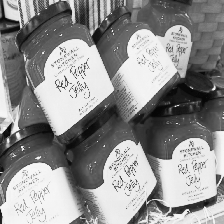

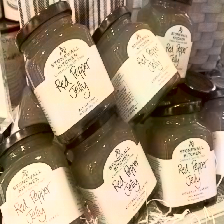

-------------------------


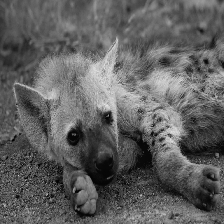

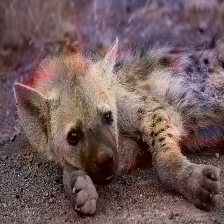

-------------------------


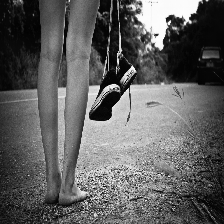

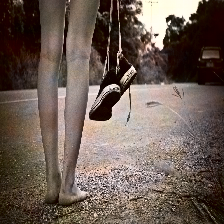

-------------------------


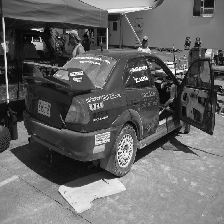

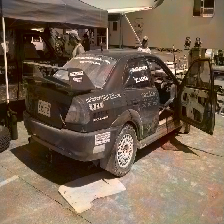

-------------------------


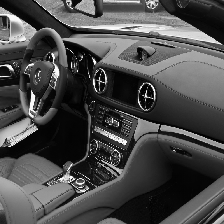

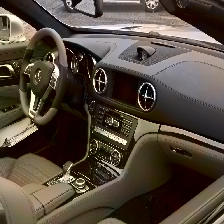

-------------------------


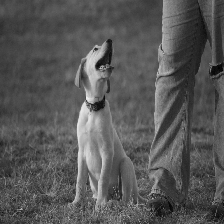

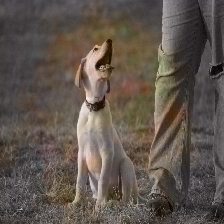

-------------------------


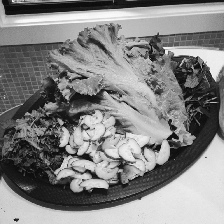

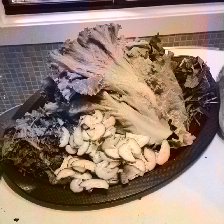

-------------------------


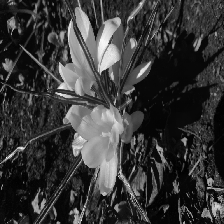

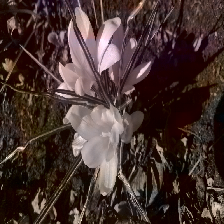

-------------------------


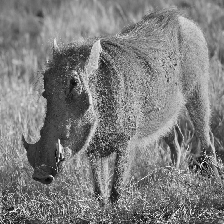

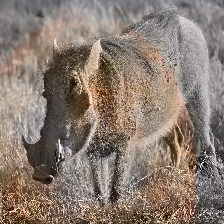

-------------------------


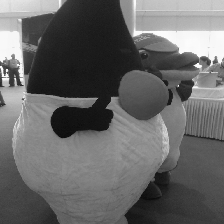

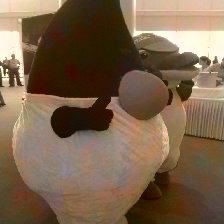

-------------------------


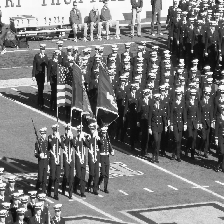

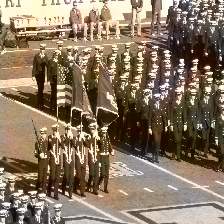

-------------------------


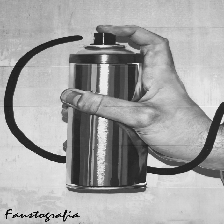

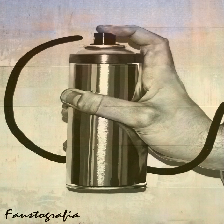

-------------------------


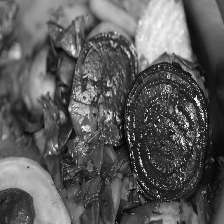

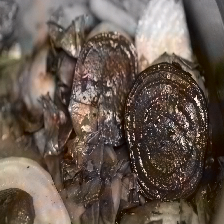

-------------------------


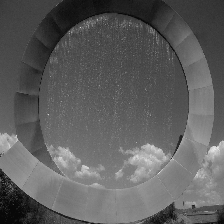

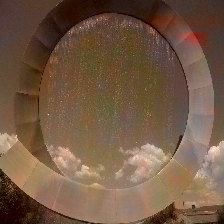

-------------------------


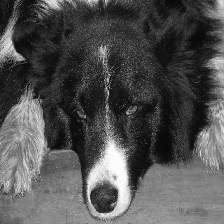

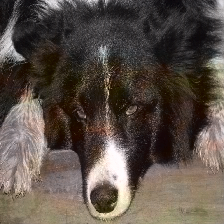

-------------------------


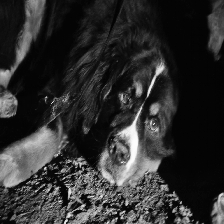

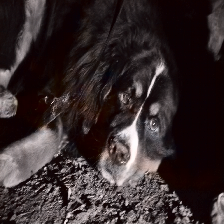

-------------------------


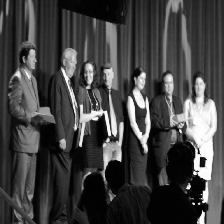

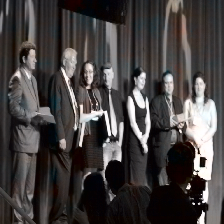

-------------------------


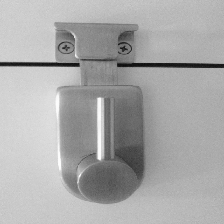

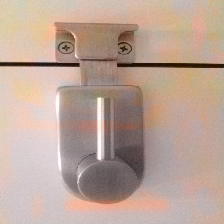

-------------------------


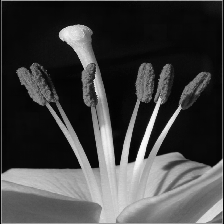

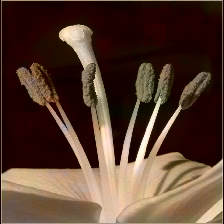

-------------------------


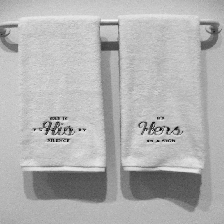

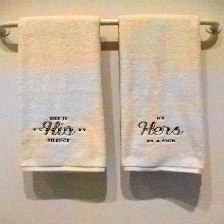

-------------------------


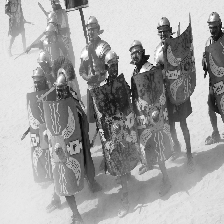

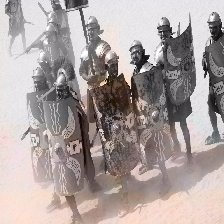

-------------------------


In [14]:
from IPython.display import display_png
from PIL import Image, ImageOps

for i in range(test_preds_rgb.shape[0]):
  gray_image = ImageOps.grayscale(array_to_img(test_preds_rgb[i]))
  display_png(gray_image)
  display_png(array_to_img(test_preds_rgb[i]))
  print('-'*25)
  if i == 20:
    break

# 事後処理: モデルの学習結果の保存とドライブへのバックアップ

In [0]:
# モデルの保存
autoencoder.save_weights('autoencoder_weights.h5')

In [0]:
# ドライブへのバックアップ
!cp autoencoder_weights.h5 drive/My\ Drive/Colab\ Notebooks/